In [1]:
# Import dependencies
import os
import numpy as np
import re
import cv2
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Input, MaxPool2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization, Cropping2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

2025-09-11 10:54:01.685126: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# path of images
bengin_images_path = 'Dataset_BUSI_with_GT/benign'
malignant_images_path = 'Dataset_BUSI_with_GT/malignant'
normal_images_path = 'Dataset_BUSI_with_GT/normal'

In [3]:
# list of images & masks
img_dir = "Dataset_BUSI_with_GT"
bengin_images = os.listdir(bengin_images_path)
malignant_images = os.listdir(malignant_images_path)
normal_images = os.listdir(normal_images_path)

In [4]:
# Merge all images
images = bengin_images + malignant_images + normal_images

In [5]:
# Find corrosponding mask

def find_mask(path):
    initial = path[:-4]
    final = path[-4:]
    return initial + '_mask'+ final

In [6]:
# Plot sample images

def plot_samples(num_samples=3):

    for _ in range(num_samples):

        plt.subplots(1, 2, figsize=(15, 10))
        idx = np.random.randint(0, len(images))
        img_path = images[idx]
        initial = img_path.split('_')
        if len(initial) > 1: img_path = initial[0]+'.png'
        typ = img_path.split(' ')[0] 
        img = Image.open(os.path.join(img_dir, typ, img_path))
        mask = Image.open(find_mask(os.path.join(img_dir, typ, img_path)))

        plt.subplot(1, 2, 1)
        plt.imshow(ImageOps.invert(img))

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        

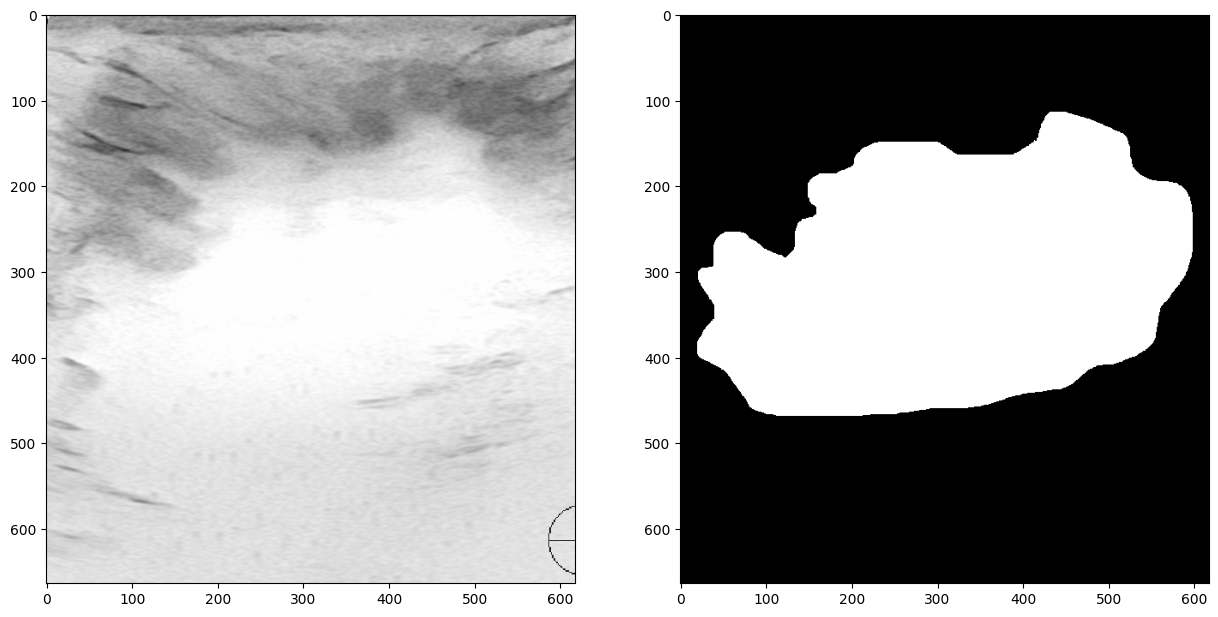

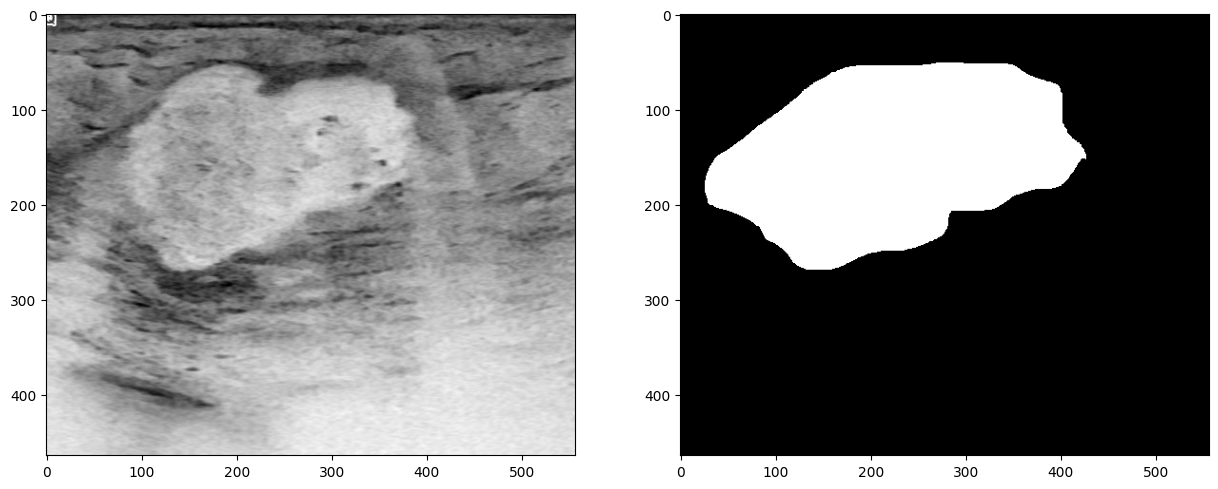

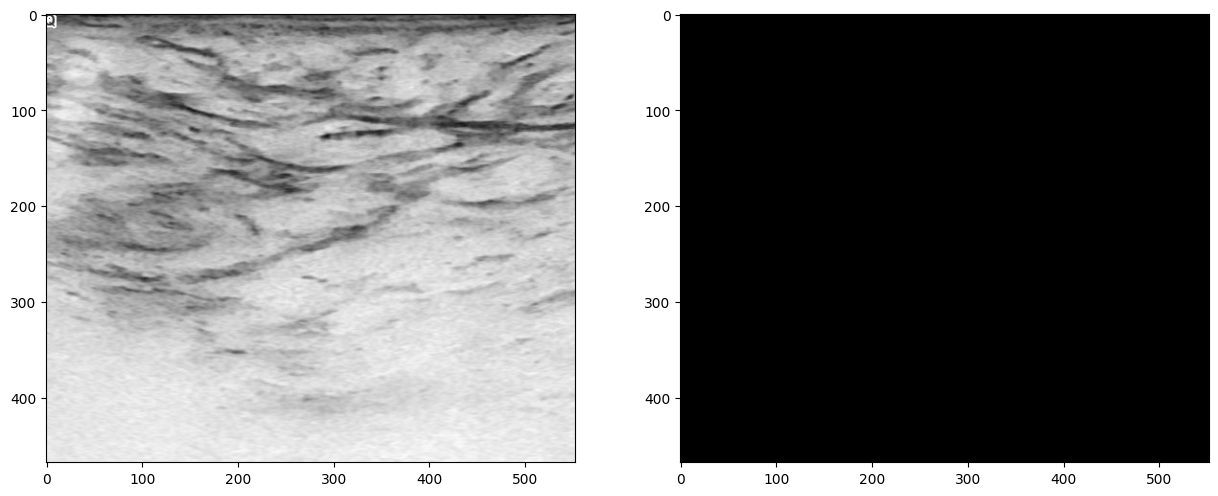

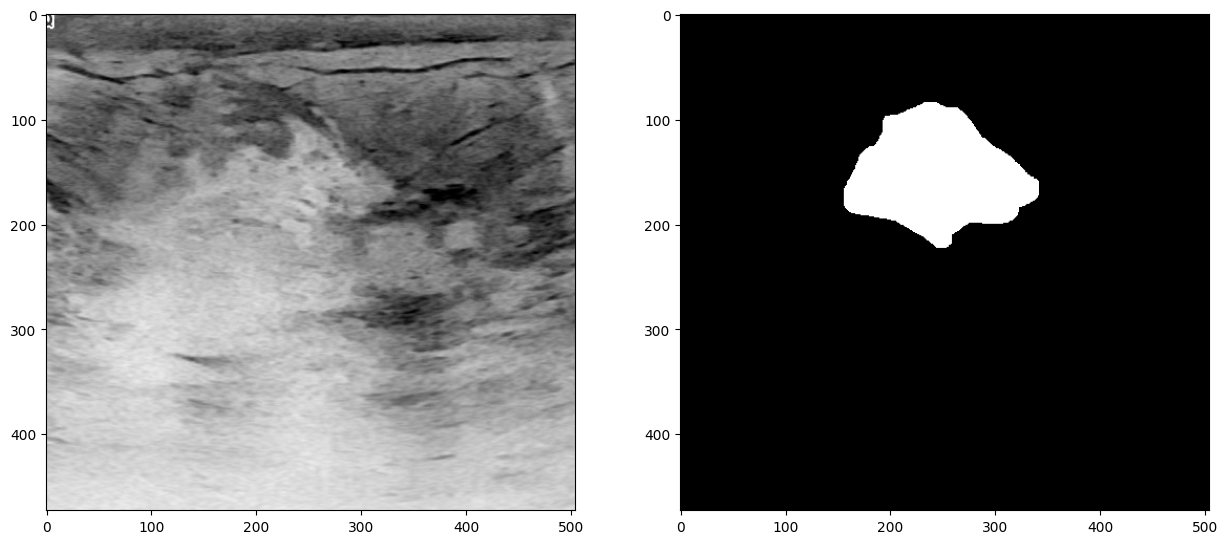

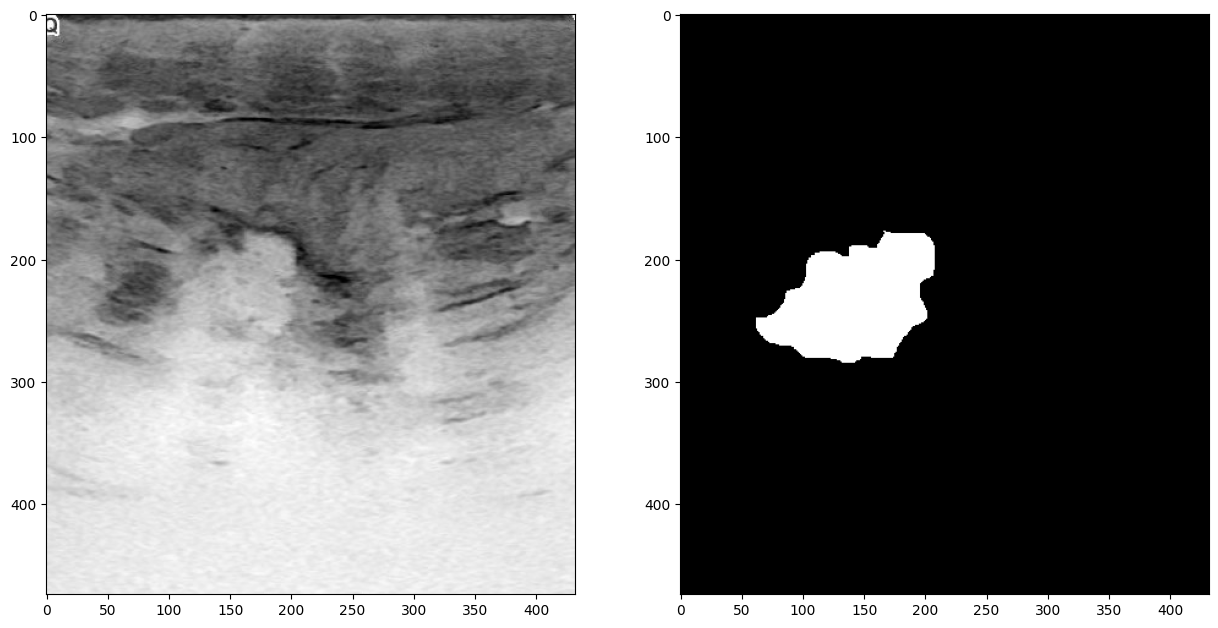

In [7]:
# Plot samples
plot_samples(5)

In [8]:
def augment_images_and_masks(images, masks):
    """
    Apply random flip, rotation, and translation to images and masks using OpenCV.
    The same transformation is applied to both images and masks.

    Args:
        images (np.ndarray): Array of images (N, H, W, C)
        masks (np.ndarray): Array of masks (N, H, W)
    Returns:
        Tuple of augmented images and masks
    """
    augmented_images = []
    augmented_masks = []

    for img, mask in zip(images, masks):
        # Random rotation between -20 and +20 degrees
        angle = np.random.uniform(-30, 30)
        h, w = img.shape[:2]
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
        img = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
        mask = cv2.warpAffine(mask, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT)

        # Random translation
        tx = np.random.uniform(-20, 20)
        ty = np.random.uniform(-20, 20)
        M_trans = np.float32([[1, 0, tx], [0, 1, ty]])
        img = cv2.warpAffine(img, M_trans, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
        mask = cv2.warpAffine(mask, M_trans, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT)

        augmented_images.append(img)
        augmented_masks.append(mask)

    return np.array(augmented_images), np.array(augmented_masks)

In [9]:
def load_data(image_dir: str, image_shape: tuple = (256, 256)):
    '''
    Load input data img & mask separately with equal distribution from each class using oversampling and augmentation.

    Args:
        image_dir (str): initial path for images directory
        image_shape (tuple): image shape after transformation

    Returns:
        tuple: containing all images list and masks list
    '''
    class_folders = ['benign', 'malignant', 'normal']
    images_by_class = {}
    masks_by_class = {}

    # Collect image names for each class (exclude masks)
    for cls in class_folders:
        folder_path = os.path.join(image_dir, cls)
        all_files = os.listdir(folder_path)
        images = [img for img in all_files if 'mask' not in img]
        masks = [find_mask(img) for img in images]
        images_by_class[cls] = images
        masks_by_class[cls] = masks

    # Find maximum number of images among classes
    max_count = max(len(images) for images in images_by_class.values())
    max_count = min(max_count, 300)

    images_list = []
    masks_list = []

    for cls in class_folders:
        imgs = images_by_class[cls]
        msks = masks_by_class[cls]
        n = len(imgs)
        # Load all images and masks
        class_images = []
        class_masks = []
        for img_name, msk_name in zip(imgs, msks):
            try:
                img = plt.imread(os.path.join(image_dir, cls, img_name))
                mask = plt.imread(os.path.join(image_dir, cls, msk_name))
            except FileNotFoundError:
                continue
            img = cv2.resize(img, image_shape)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            mask = cv2.resize(mask, image_shape, interpolation=cv2.INTER_NEAREST)
            if mask.ndim == 3:
                mask = mask[:, :, 0]
            class_images.append(img)
            class_masks.append(mask)
        class_images = np.array(class_images)
        class_masks = np.array(class_masks)

        # Oversample with augmentation if needed
        if n < max_count:
            aug_images = []
            aug_masks = []
            while len(class_images) + len(aug_images) < max_count:
                # Sample a batch to augment
                batch_size = min(max_count - (len(class_images) + len(aug_images)), n)
                idxs = np.random.choice(n, batch_size, replace=True)
                imgs_to_aug = class_images[idxs]
                msks_to_aug = class_masks[idxs]
                X_aug, y_aug = augment_images_and_masks(imgs_to_aug, msks_to_aug)
                aug_images.append(X_aug)
                aug_masks.append(y_aug)
            aug_images = np.concatenate(aug_images, axis=0)
            aug_masks = np.concatenate(aug_masks, axis=0)
            class_images = np.concatenate([class_images, aug_images], axis=0)
            class_masks = np.concatenate([class_masks, aug_masks], axis=0)
            # If we have slightly more than max_count, trim
            class_images = class_images[:max_count]
            class_masks = class_masks[:max_count]

        images_list.append(class_images)
        masks_list.append(class_masks)

    images_array = np.concatenate(images_list, axis=0)
    masks_array = np.concatenate(masks_list, axis=0)
    print(images_array.shape, masks_array.shape)
    return images_array, masks_array

In [10]:
pro_images, pro_masks = load_data(img_dir)

(1037, 256, 256) (1037, 256, 256)


In [11]:
print(pro_images.shape)
print(pro_masks.shape)

(1037, 256, 256)
(1037, 256, 256)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(pro_images, pro_masks, test_size=0.2, random_state=42)

In [13]:
# print shape of splitted data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((829, 256, 256), (208, 256, 256), (829, 256, 256), (208, 256, 256))

# **U-Net Architecture from Sratch**

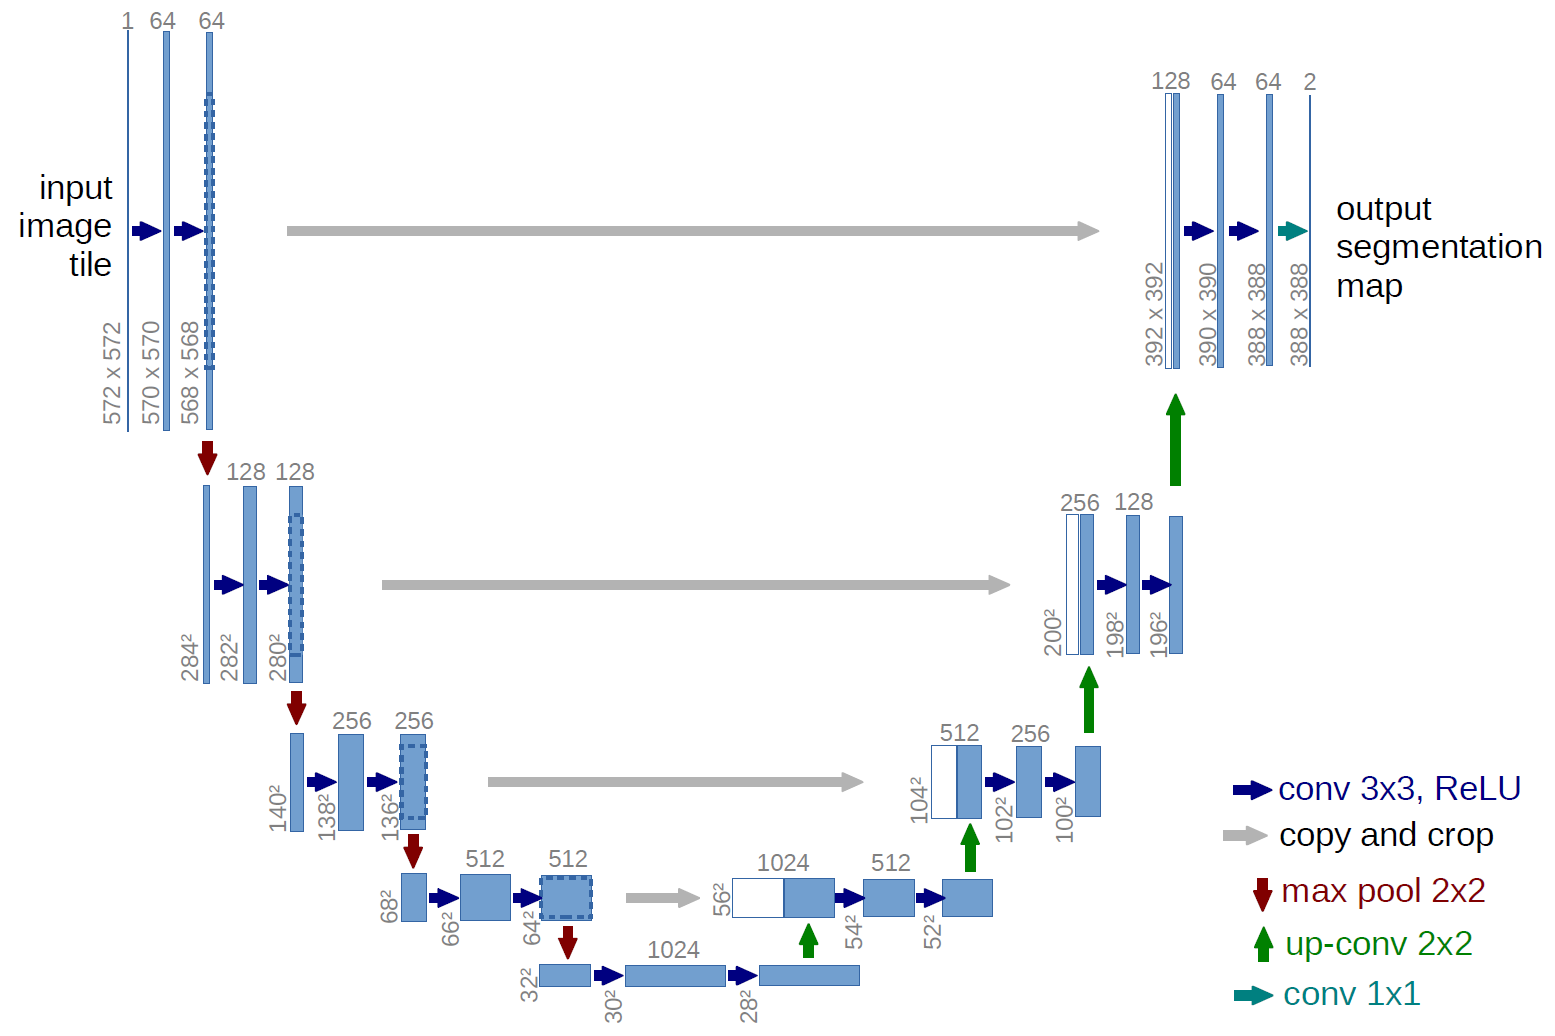

## **Building Convolution Block**

In [14]:
# Function to create convolution block in u-net Architecture

def Convolution_block(input_tensor : tf.Tensor, num_filters : int, kernel_size : tuple = (3, 3), use_batch_norm = False):
    ''' 
    perform two convolution operation with optional batch normalization
     
    Arg:
        input_tensor(tensor): input for convolution operation
        num_filters(int): number of filters for each convolution layers
        kernel_size(tuple): size of kernel for each convolution operation
        use_batch_norm(boolean): boolean input to use batch normalization 
    
    Return:
           tensor : after building convolution block with convolution layers
    '''

    # First Convolution
    x = Conv2D(filters=num_filters, kernel_size = kernel_size, padding='same', kernel_initializer = 'he_normal')(input_tensor)

    if use_batch_norm:
        x = BatchNormalization()(x)

    # Second Convolution
    x = Conv2D(filters=num_filters, kernel_size = kernel_size, padding='same', kernel_initializer = 'he_normal')(x)

    if use_batch_norm:
        x = BatchNormalization()(x)

    return x

# Function to crop & concatenate Convolution layers

def crop_concat(upsampled, skip):

    """Crop skip connection to match upsampled tensor size before concatenation."""
    up_shape = K.int_shape(upsampled)
    skip_shape = K.int_shape(skip)

    height_diff = skip_shape[1] - up_shape[1]
    width_diff  = skip_shape[2] - up_shape[2]

    if height_diff != 0 or width_diff != 0:
        skip = Cropping2D(((height_diff // 2, height_diff - height_diff // 2),
                           (width_diff // 2, width_diff - width_diff // 2)))(skip)
    return concatenate([upsampled, skip])


## **Bulding U-Net Model**

In [15]:
# Function to build U-Net Model

def Build_Unet(input_shape: tuple, num_filters=16, dropout_rate: float = 0.1, use_batch_norm: bool = True):

    inputs = Input(input_shape)

    # Encoder
    c1 = Convolution_block(inputs, num_filters, kernel_size=(3,3), use_batch_norm=use_batch_norm)
    p1 = MaxPool2D((2, 2))(c1)
    p1 = Dropout(dropout_rate)(p1)

    c2 = Convolution_block(p1, num_filters*2, kernel_size=(3,3), use_batch_norm=use_batch_norm)
    p2 = MaxPool2D((2, 2))(c2)
    p2 = Dropout(dropout_rate)(p2)

    c3 = Convolution_block(p2, num_filters*4, kernel_size=(3,3), use_batch_norm=use_batch_norm)
    p3 = MaxPool2D((2, 2))(c3)
    p3 = Dropout(dropout_rate)(p3)

    c4 = Convolution_block(p3, num_filters*8, kernel_size=(3,3), use_batch_norm=use_batch_norm)
    p4 = MaxPool2D((2, 2))(c4)
    p4 = Dropout(dropout_rate)(p4)

    # Bottleneck
    c5 = Convolution_block(p4, num_filters*16, kernel_size=(3,3), use_batch_norm=use_batch_norm)

    # Decoder
    u6 = Conv2DTranspose(num_filters*8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = crop_concat(u6, c4)
    u6 = Dropout(dropout_rate)(u6)
    c6 = Convolution_block(u6, num_filters*8, use_batch_norm=use_batch_norm)

    u7 = Conv2DTranspose(num_filters*4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = crop_concat(u7, c3)
    u7 = Dropout(dropout_rate)(u7)
    c7 = Convolution_block(u7, num_filters*4, use_batch_norm=use_batch_norm)

    u8 = Conv2DTranspose(num_filters*2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = crop_concat(u8, c2)
    u8 = Dropout(dropout_rate)(u8)
    c8 = Convolution_block(u8, num_filters*2, use_batch_norm=use_batch_norm)

    u9 = Conv2DTranspose(num_filters, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = crop_concat(u9, c1)  
    u9 = Dropout(dropout_rate)(u9)
    c9 = Convolution_block(u9, num_filters, use_batch_norm=use_batch_norm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model


In [16]:
# Initialize & compile  U-Net Model
input_shape = (256, 256, 1)
model = Build_Unet(input_shape)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

I0000 00:00:1757566466.170243  521184 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22196 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:0b:00.0, compute capability: 8.6


In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_5[0][0]  

 Total params: 2,164,305 (8.26 MB)

 Trainable params: 2,161,361 (8.24 MB)

 Non-trainable params: 2,944 (11.50 KB)

/home/shantanurahman/personal/medical-segmentation/.venv/lib/python3.12/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


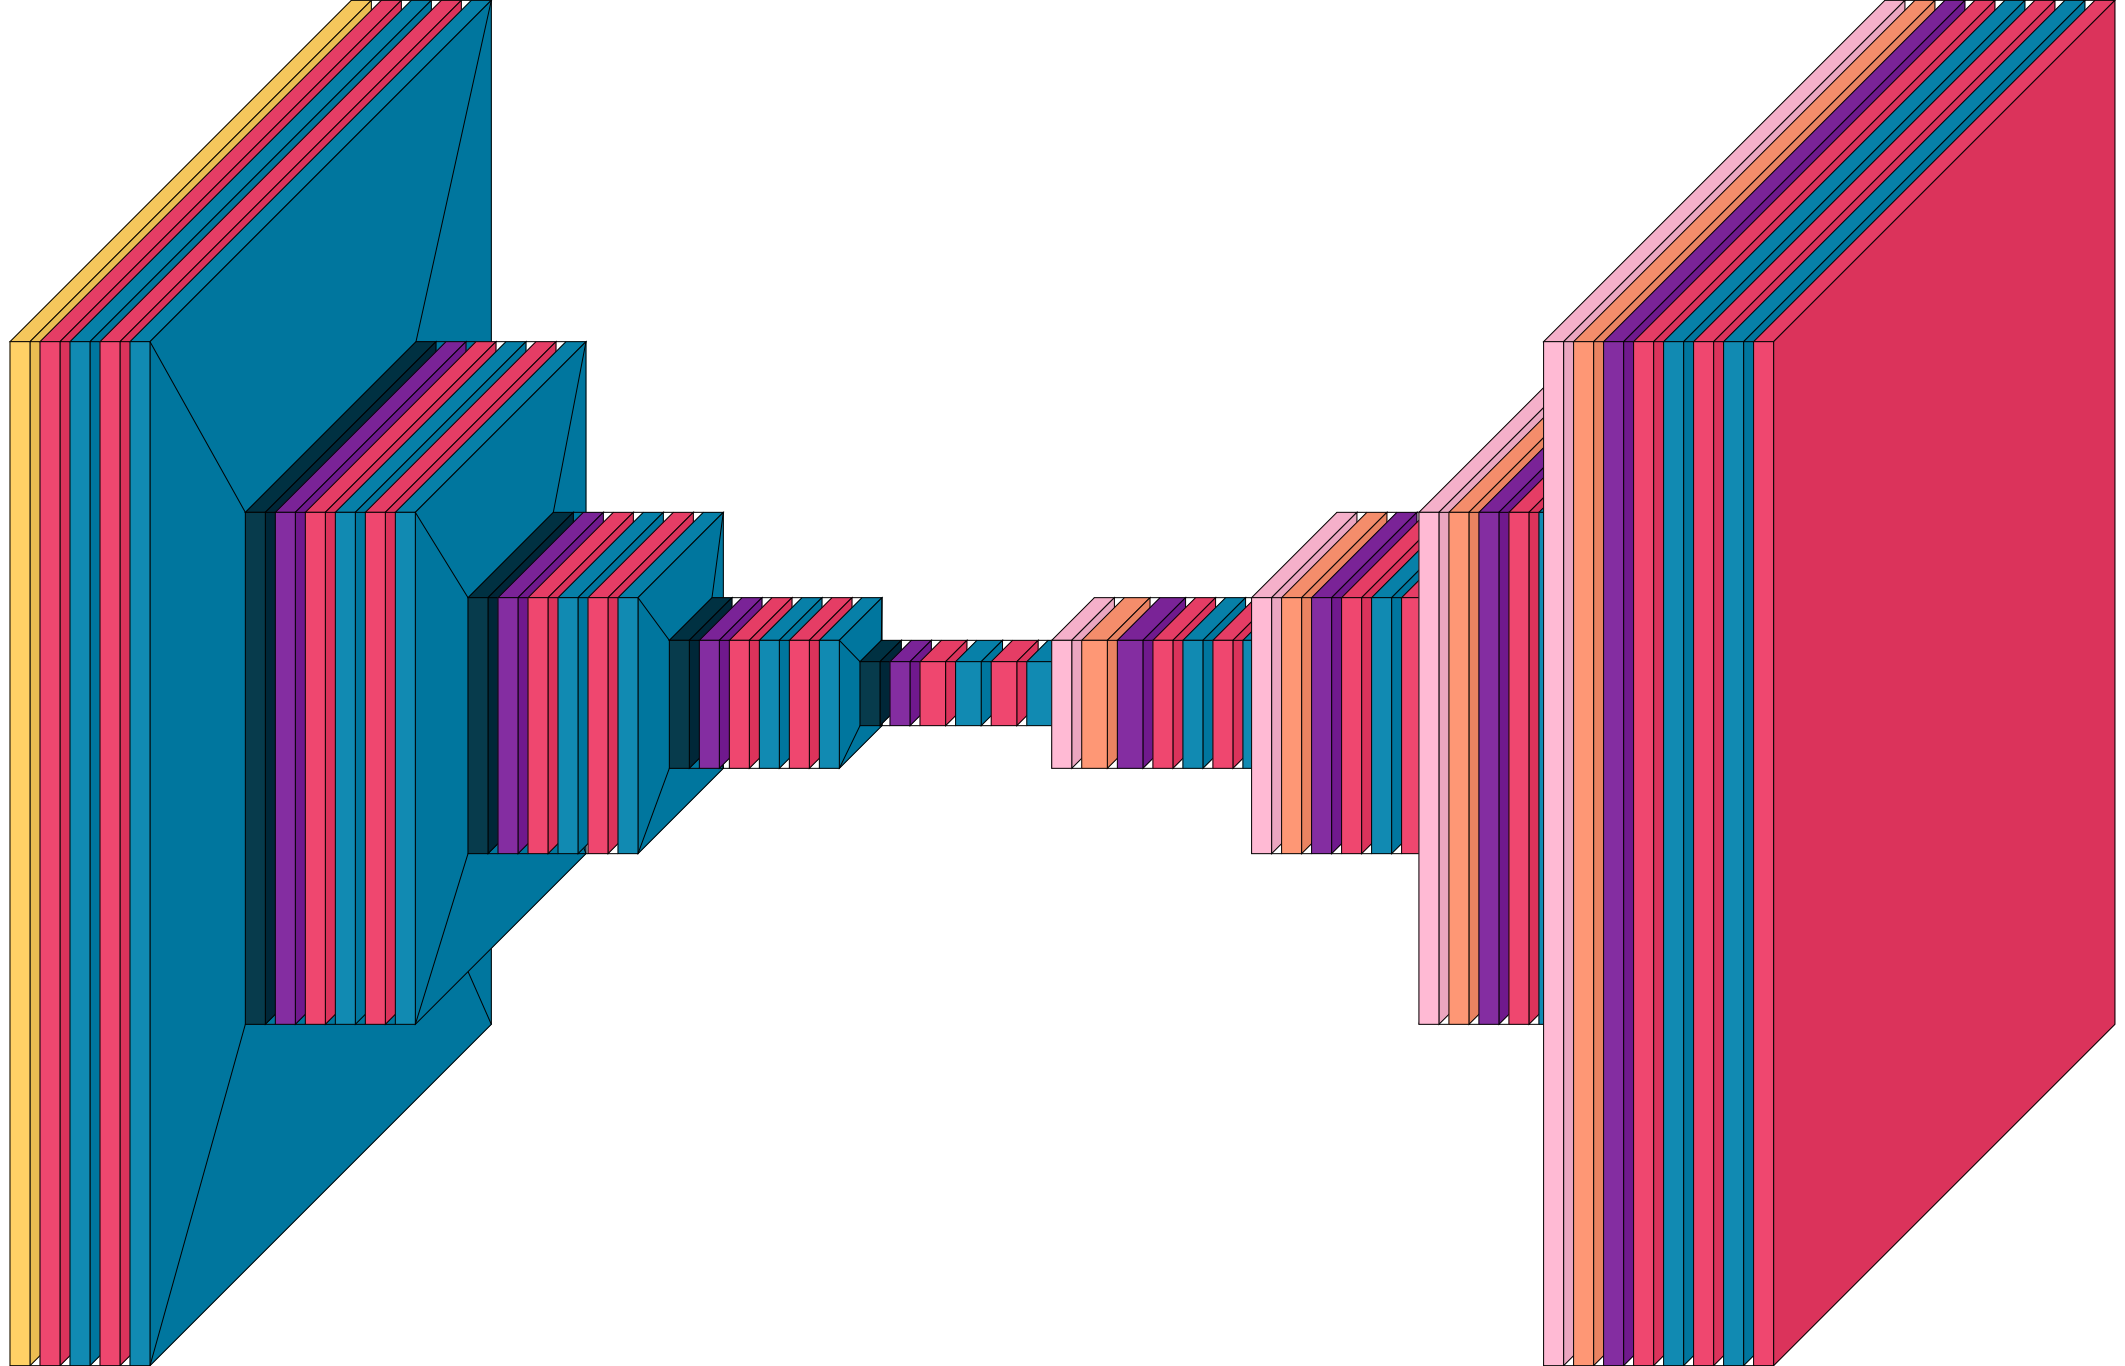

In [18]:
from visualkeras import layered_view
layered_view(model)

In [19]:
# Callbacks 

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights = True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor = 0.5, verbose=1, min_lr = 1e-6 )
model_checkpoint = ModelCheckpoint('Unet_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

In [20]:
X_train.shape

(829, 256, 256)

In [21]:
history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 70,
    verbose= 1,
    callbacks = [early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/70


2025-09-11 10:54:32.954077: I external/local_xla/xla/service/service.cc:163] XLA service 0x72462000dd80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-11 10:54:32.954094: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-09-11 10:54:33.122881: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-11 10:54:33.930089: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300


 2/26 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.4813 - loss: 0.8228 

I0000 00:00:1757566489.070665  521437 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.5540 - loss: 0.7165
Epoch 1: val_loss improved from None to 14.47472, saving model to Unet_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 775ms/step - accuracy: 0.6210 - loss: 0.6715 - val_accuracy: 0.0915 - val_loss: 14.4747 - learning_rate: 0.0010
Epoch 2/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7520 - loss: 0.6018
Epoch 2: val_loss improved from 14.47472 to 14.32907, saving model to Unet_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.7703 - loss: 0.5872 - val_accuracy: 0.0954 - val_loss: 14.3291 - learning_rate: 0.0010
Epoch 3/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8215 - loss: 0.5405
Epoch 3: val_loss improved from 14.32907 to 11.86345, saving model to Unet_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.8332 - loss: 0.5270 - val_accuracy: 0.2221 - val_loss: 11.8635 - learning_rate: 0.0010
Epoch 4/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accur

Text(0.5, 1.0, 'Loss')

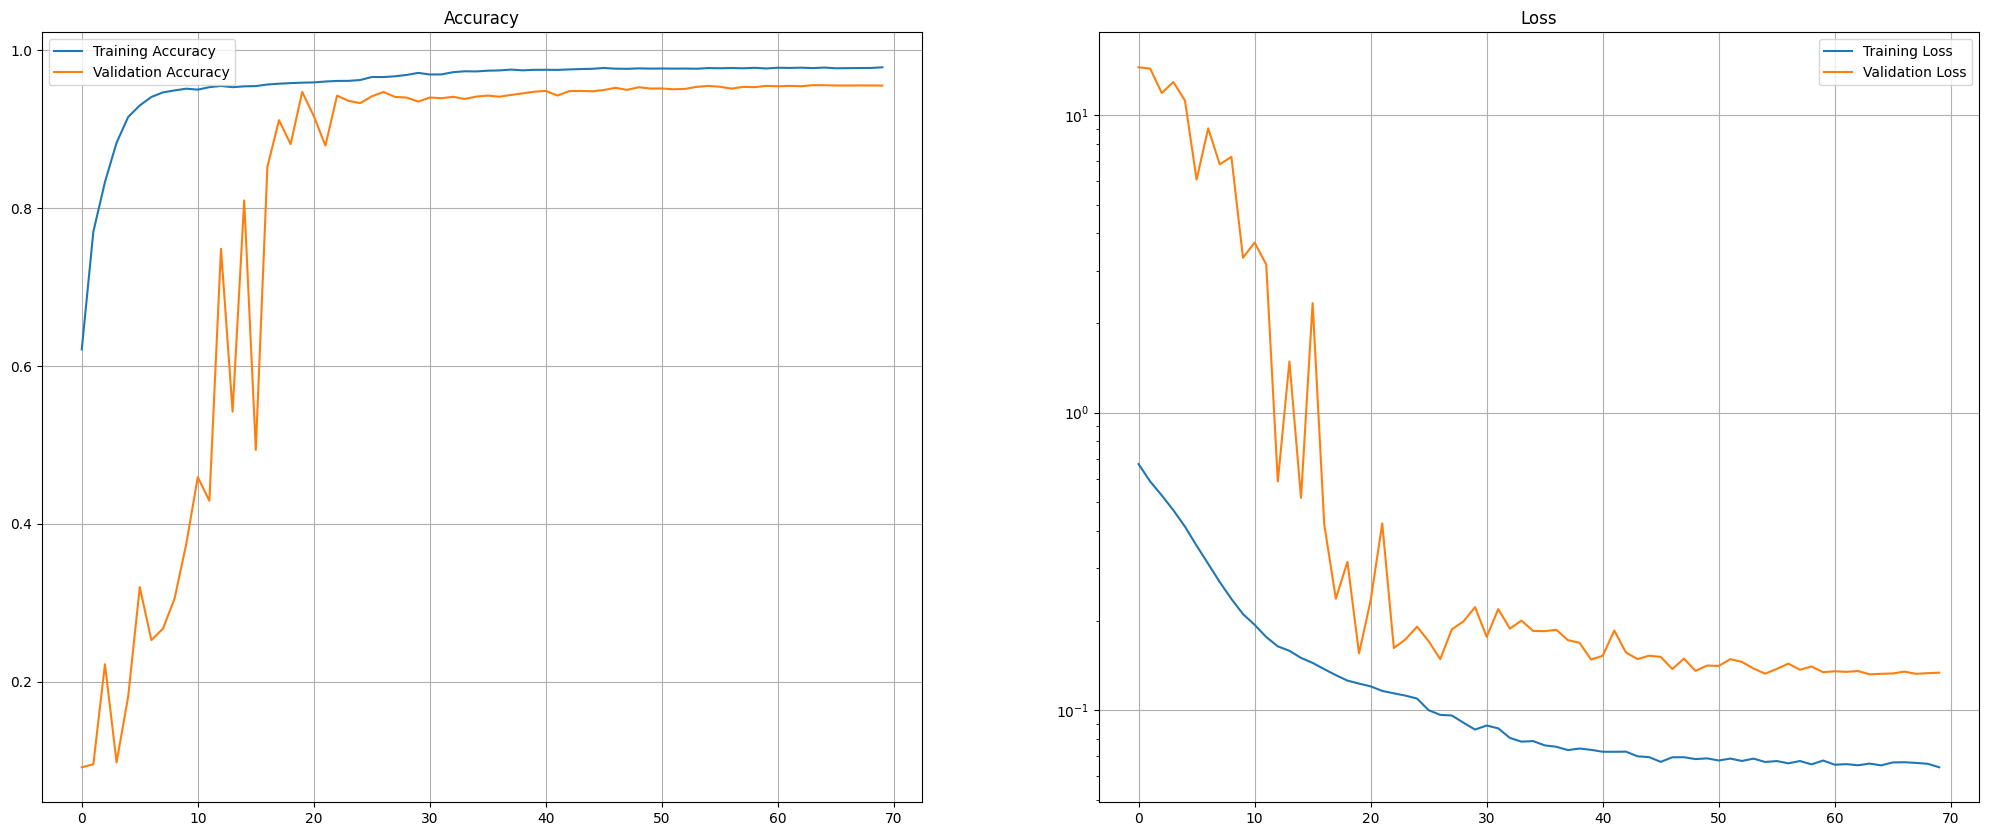

In [28]:
# Plot training & validation accuracy & loss

plt.subplots(1, 2, figsize = (25, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.grid()
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.semilogy(history.history['loss'], label='Training Loss')
plt.semilogy(history.history['val_loss'], label='Validation Loss')
plt.grid()
plt.legend()
plt.title('Loss')


In [23]:
# Get infrence of sigle image & time of infrenc_aug e

def predict_mask(input):
    """
    Predict a segmenation of a given image & calculate the time of infrence

    Arg:
        image(Numpy Array): input image for prediction
        model(keras.Model): model going to use for prediction

    Return: Predicted Mask & Inference time
    """

    start_time = time.time()
    prediction = model.predict(np.expand_dims(input, axis=0), verbose=0)[0, :, :, 0]
    end_time = time.time()
    inference_time = end_time - start_time
    
    return prediction, inference_time

In [24]:
# Function to visualize predictions & ground truth

def visualize_segmented_mask(image, pred_mask, org_mask):
    """
    visualizes the image, predicted mask, and original mask

    Arg: 
        image(Array): Orginal Image which we have to segment
        pred_mask(Array): Model predicted mask
        org_mask(Array): Original mask
    """
    plt.subplots(1, 3, figsize=(20, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Mask')

    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask)
    plt.title('Predicted Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(org_mask)
    plt.title('Original Mask')


In [25]:
# Function to inference & visualise some samples of test data

def get_predictions(num_samples):
    """
    Inference & visualise some test data samples

    Arg: 
        num_samples(int): number of samples to inference & visualize
        
    """

    for _ in range(num_samples):
        index = np.random.randint(0, len(X_test))
        img = X_test[index]
        org_mask = y_test[index]
        pred_mask, inference_time = predict_mask(img)
        binary_mask = (pred_mask > 0.5).astype(np.uint8)
        visualize_segmented_mask(img, pred_mask, org_mask)
        print(f'Time taken to inference:{inference_time}')

Time taken to inference:1.11037015914917
Time taken to inference:0.04216456413269043
Time taken to inference:0.04346036911010742


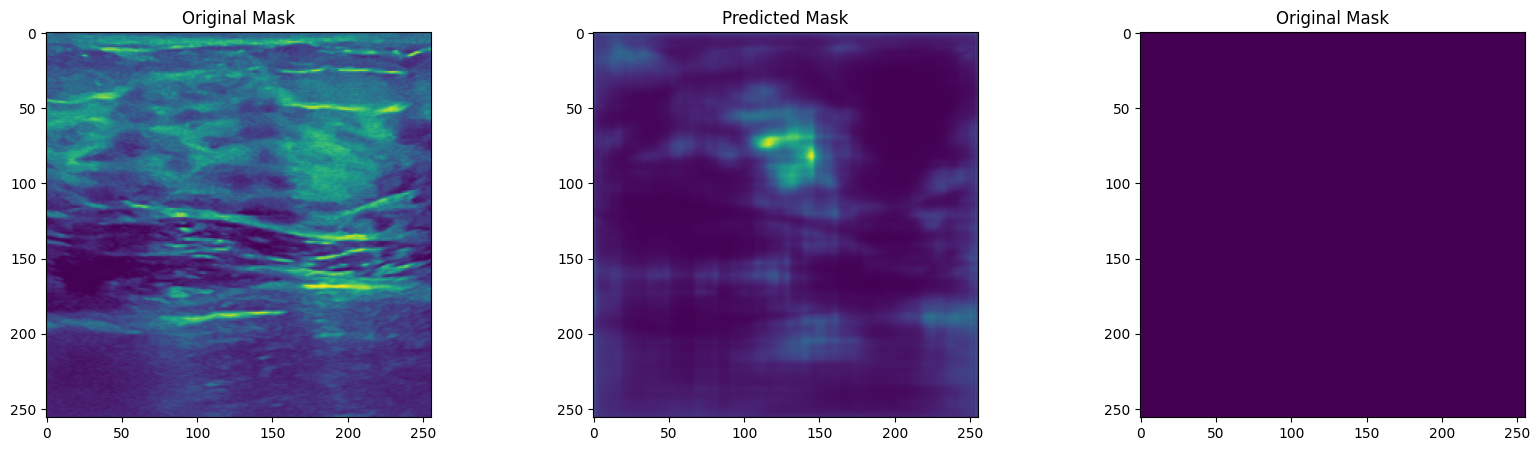

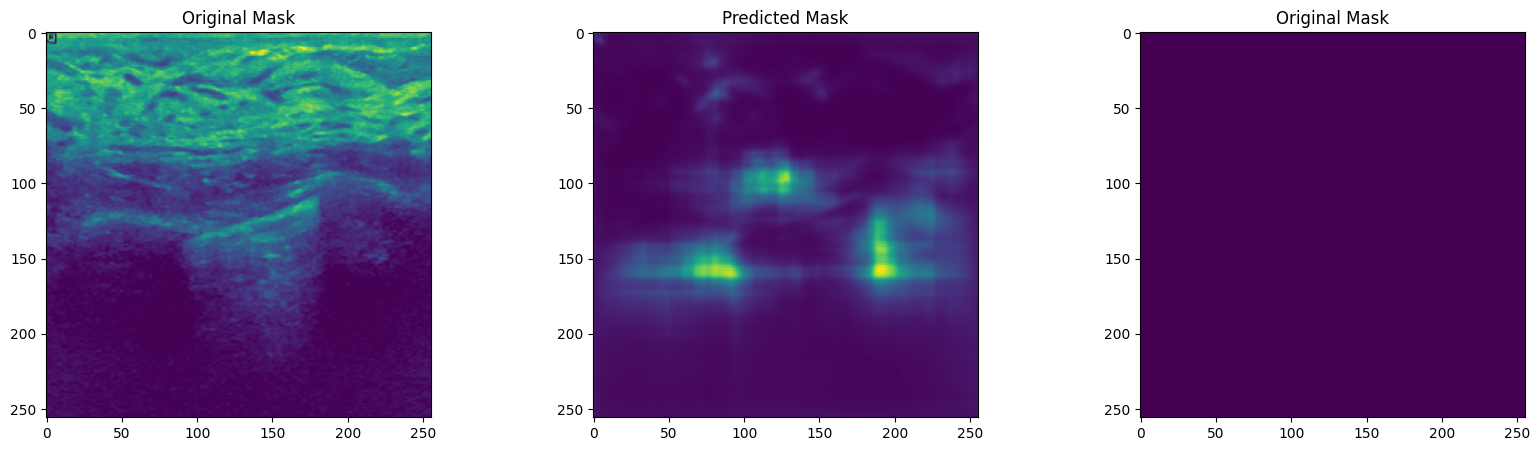

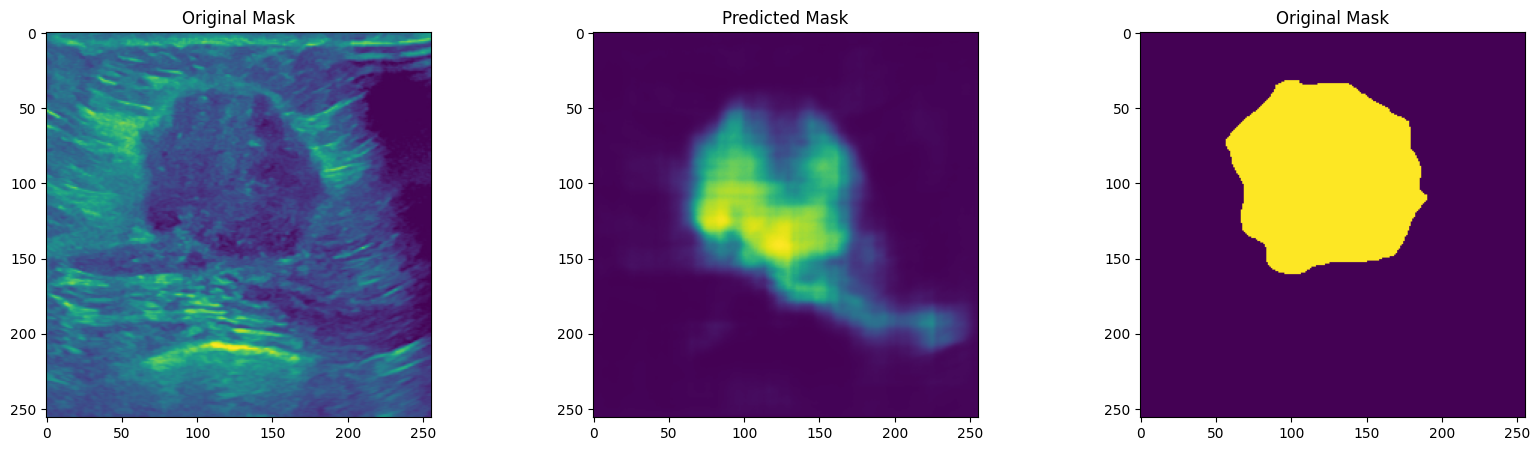

In [26]:
# visualize some predictions 
get_predictions(3)

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

# Ensure X_test has shape (batch, 256, 256, 1)
if X_test.ndim == 3:
	X_test_input = X_test[..., np.newaxis]
else:
	X_test_input = X_test

# Predict masks for X_test
y_pred = model.predict(X_test)
y_pred_bin = (y_pred > 0.5).astype(np.uint8).squeeze()

# Flatten arrays for metric calculation
y_true_flat = y_test.flatten()
y_pred_flat = y_pred_bin.flatten()

# Calculate metrics
accuracy = accuracy_score(y_true_flat, y_pred_flat)
precision = precision_score(y_true_flat, y_pred_flat, zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, zero_division=0)
f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0)
iou = jaccard_score(y_true_flat, y_pred_flat, zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"IoU (Jaccard): {iou:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
Accuracy: 0.9559
Precision: 0.8203
Recall: 0.4829
F1 Score: 0.6079
IoU (Jaccard): 0.4367
